<a href="https://colab.research.google.com/github/Nageswar-Sahoo/Computer-Vision-Project/blob/main/s13/Untitled63.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nageswarsahoo","key":"828fafc72892326f87f03374ca524ceb"}'}

In [9]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
rm -rf  ~/kaggle

In [17]:
!ls  ~/.kaggle

kaggle.json


In [16]:
! cp  kaggle.json ~/.kaggle

In [20]:
! chmod 600 /root/.kaggle/kaggle.json

In [22]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18581  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          11250  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5768  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3963  
nickuzmenkov/nih-chest-xrays-tfrecords                      NIH Chest X-rays

In [23]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 96% 524M/544M [00:02<00:00, 194MB/s]
100% 544M/544M [00:02<00:00, 191MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 93.3MB/s]
100% 271M/271M [00:02<00:00, 156MB/s]



In [24]:
ls -lh

total 815M
-rw-r--r-- 1 root root   69 Jan  9 14:23 kaggle.json
drwxr-xr-x 1 root root 4.0K Dec 23 14:32 sample_data/
-rw-r--r-- 1 root root 112K Jan  9 14:30 sample_submission.csv
-rw-r--r-- 1 root root 272M Jan  9 14:30 test.zip
-rw-r--r-- 1 root root 544M Jan  9 14:30 train.zip


In [26]:
!pip install vit-pytorch linformer



     |████████████████████████████████| 50 kB 2.7 MB/s 


In [27]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset
import zipfile   
from sklearn.model_selection import train_test_split  



In [31]:
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

In [32]:
os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'


In [33]:
#Unzipping dataset
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [34]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [35]:
#Defining labels

labels = [path.split('/')[-1].split('.')[0] for path in train_list]

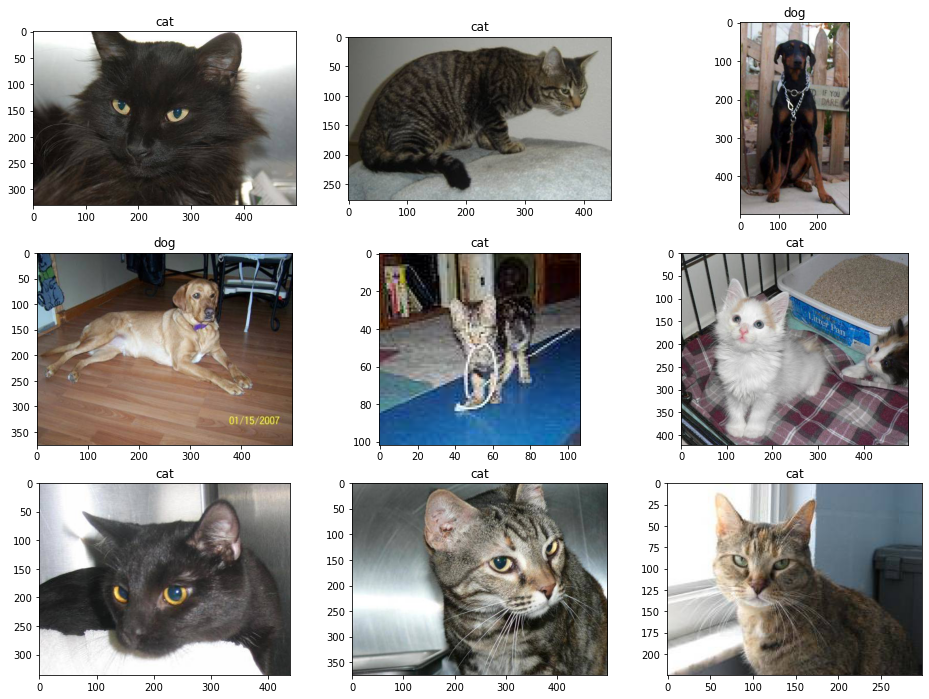

In [36]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [38]:
#Splitting train and validation list

train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [39]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [40]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [41]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [42]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [43]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [44]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [48]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [50]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)
# loss function

criterion = nn.CrossEntropyLoss()
# optimizer

optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [51]:
#start training

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6973 - acc: 0.5088 - val_loss : 0.6917 - val_acc: 0.5190



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6900 - acc: 0.5294 - val_loss : 0.6864 - val_acc: 0.5461



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6847 - acc: 0.5507 - val_loss : 0.6755 - val_acc: 0.5799



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6776 - acc: 0.5696 - val_loss : 0.6874 - val_acc: 0.5585



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6738 - acc: 0.5746 - val_loss : 0.6706 - val_acc: 0.5773



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6665 - acc: 0.5905 - val_loss : 0.6664 - val_acc: 0.5890



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6597 - acc: 0.5955 - val_loss : 0.6500 - val_acc: 0.6112



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6480 - acc: 0.6126 - val_loss : 0.6438 - val_acc: 0.6181



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6396 - acc: 0.6220 - val_loss : 0.6395 - val_acc: 0.6232



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6315 - acc: 0.6331 - val_loss : 0.6326 - val_acc: 0.6264



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6223 - acc: 0.6463 - val_loss : 0.6409 - val_acc: 0.6272



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6159 - acc: 0.6539 - val_loss : 0.6186 - val_acc: 0.6572



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6112 - acc: 0.6579 - val_loss : 0.6284 - val_acc: 0.6349



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6085 - acc: 0.6642 - val_loss : 0.6102 - val_acc: 0.6600



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6021 - acc: 0.6622 - val_loss : 0.6076 - val_acc: 0.6614



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.5943 - acc: 0.6755 - val_loss : 0.6033 - val_acc: 0.6648



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.5952 - acc: 0.6744 - val_loss : 0.5979 - val_acc: 0.6731



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5905 - acc: 0.6781 - val_loss : 0.5975 - val_acc: 0.6756



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5901 - acc: 0.6793 - val_loss : 0.5921 - val_acc: 0.6774



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5821 - acc: 0.6876 - val_loss : 0.5919 - val_acc: 0.6695

